In [1]:
import h5py
import os

import fenics as fe
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

from tqdm import tqdm

import sys
sys.path.insert(0, "../scripts/")

from mpi4py import MPI
from swe_2d import ShallowTwo

fe.set_log_level(50)

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


In [2]:
ds = xr.open_dataset("../data/Run08_G0_dt4.0_de1.0_ne5_velocity.nc")

u_spatial_averaged = np.mean(ds.U, axis=(1, 2, 3))
v_spatial_averaged = np.mean(ds.V, axis=(1, 2, 3))

idx_start = np.argmin(np.abs(u_spatial_averaged.values - 0.))
idx_end = len(u_spatial_averaged.values)

In [3]:
u_depth_averaged = np.mean(ds.U, axis=-1)
v_depth_averaged = np.mean(ds.V, axis=-1)

u_depth_averaged = u_depth_averaged.isel(time=slice(idx_start, idx_end))
v_depth_averaged = v_depth_averaged.isel(time=slice(idx_start, idx_end))

u_spatial_averaged = u_spatial_averaged.isel(time=slice(idx_start, idx_end))
v_spatial_averaged = v_spatial_averaged.isel(time=slice(idx_start, idx_end))

u_depth_averaged = u_depth_averaged.assign_coords(
    dict(time_rel=((u_depth_averaged["time"]  - u_depth_averaged["time"][0]) * 1e-9).astype(float)))
v_depth_averaged = v_depth_averaged.assign_coords(
    dict(time_rel=((v_depth_averaged["time"]  - v_depth_averaged["time"][0]) * 1e-9).astype(float)))

u_spatial_averaged = u_spatial_averaged.assign_coords(
    dict(time_rel=((u_spatial_averaged["time"]  - u_spatial_averaged["time"][0]) * 1e-9).astype(float)))
v_spatial_averaged = v_spatial_averaged.assign_coords(
    dict(time_rel=((v_spatial_averaged["time"]  - v_spatial_averaged["time"][0]) * 1e-9).astype(float)))

In [4]:
r = 0.05
ds_zero = ds.isel(time=0)
ds_zero_missing = ds_zero.where(ds_zero.isnull(), drop=True)

x_missing = ds_zero_missing.coords["x"][:]
y_missing = ds_zero_missing.coords["y"][:]

B = 1
L = 2
# find 
x_displacement = np.min(ds_zero.coords["x"][ds_zero.coords["x"] > np.max(x_missing)])
print(x_displacement)

x_global_displacement = L / 2 + r - x_displacement

<xarray.DataArray 'x' ()>
array(0.04224, dtype=float32)
Coordinates:
    time     datetime64[ns] 2016-07-14T23:41:56.464000


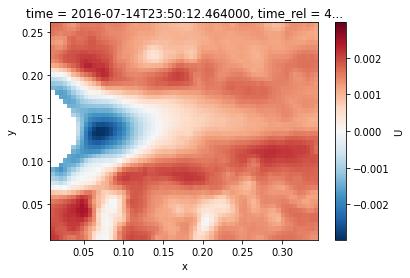

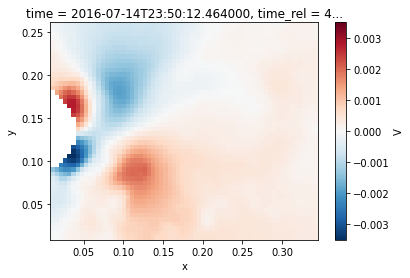

<xarray.DataArray 'time' ()>
array('2016-07-14T23:50:12.464000000', dtype='datetime64[ns]')
Coordinates:
    time      datetime64[ns] 2016-07-14T23:50:12.464000
    time_rel  float64 420.0


In [5]:
u_depth_averaged.isel(time=105).plot(x="x", y="y")
plt.show()

v_depth_averaged.isel(time=105).plot(x="x", y="y")
plt.show()

print(u_depth_averaged.isel(time=105).coords["time"])

In [6]:
output_file = "../outputs/branson-run-8-cn-test.h5"
outputs = h5py.File(output_file, "r")

coords = outputs["x"][:]
t = outputs["t"][:]
x, y = coords[:, 0], coords[:, 1]
u_out = outputs["u"][:]
v_out = outputs["v"][:]
outputs.close()

In [7]:
# create mask for computing area of interest
mask = np.logical_and(x >= 1., x <= 1.33)
mask = np.logical_and(mask, y >= 0.375)
mask = np.logical_and(mask, y <= 0.625)

420.05000000006123


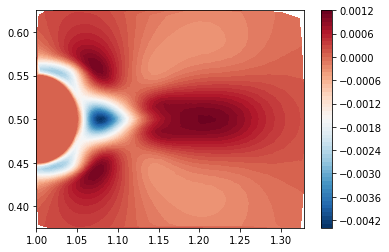

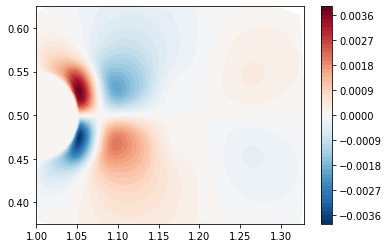

In [8]:
idx_plot = 4200
print(t[idx_plot])
im = plt.tricontourf(x[mask], y[mask], u_out[idx_plot, mask], 64, cmap="RdBu_r")
plt.colorbar(im)
plt.show()

im = plt.tricontourf(x[mask], y[mask], v_out[idx_plot, mask], 64, cmap="RdBu_r")
plt.colorbar(im)
plt.show()

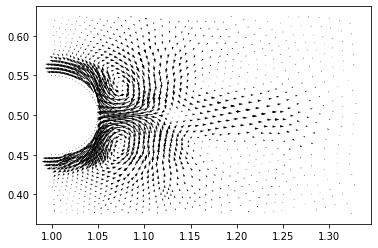

In [9]:
plt.quiver(x[mask], y[mask], u_out[idx_plot, mask], v_out[idx_plot, mask])
plt.show()

In [10]:
nt = len(t)

u_ave = np.zeros((nt, ))
v_ave = np.zeros((nt, ))
for i in range(nt):
    u_ave[i] = np.mean(u_out[i, mask])
    v_ave[i] = np.mean(v_out[i, mask])

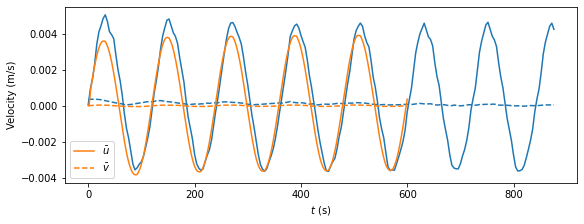

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3), constrained_layout=True)
u_spatial_averaged.plot(x="time_rel", ax=ax, color="tab:blue")
v_spatial_averaged.plot(x="time_rel", ax=ax, color="tab:blue", ls="--")

ax.plot(
    t,  u_ave, 
    ls="-", color="tab:orange", label=r"$\bar u$")
ax.plot(
    t, v_ave, 
    ls="--", color="tab:orange", label=r"$\bar v$")
ax.legend()

ax.set_xlabel(r"$t$ (s)")
ax.set_ylabel(r"Velocity (m/s)")
    
plt.show()

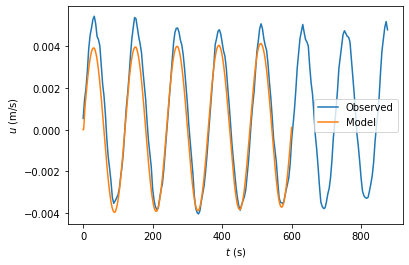

In [12]:
x_nearest = np.array([1.3, 0.5])
u_depth_averaged.isel(
    x=np.argmin(np.abs(
        u_depth_averaged.coords["x"].values + x_global_displacement.values - x_nearest[0])), 
    y=24).plot(x="time_rel", label="Observed")
plt.plot(
    t, u_out[:, np.argmin(np.sum(np.abs(coords - x_nearest), axis=1))],
    label="Model")
plt.ylabel("$u$ (m/s)")
plt.xlabel("$t$ (s)")
plt.title("")
plt.legend()
plt.show()